## Imports

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [117]:
web_visits = pd.read_csv('data/web_visits.csv')
web_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259340 entries, 0 to 259339
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   member_id    259340 non-null  int64 
 1   url          259340 non-null  object
 2   title        259340 non-null  object
 3   description  259340 non-null  object
 4   timestamp    259340 non-null  object
dtypes: int64(1), object(4)
memory usage: 9.9+ MB


In [118]:
app_usage = pd.read_csv('data/app_usage.csv')
# drop "event_type" column from app_usage DataFrame (all values are the same)
app_usage.drop(columns=['event_type'], inplace=True)
app_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97789 entries, 0 to 97788
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   member_id  97789 non-null  int64 
 1   timestamp  97789 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [119]:
claims = pd.read_csv('data/claims.csv')
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64576 entries, 0 to 64575
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   member_id       64576 non-null  int64 
 1   icd_code        64576 non-null  object
 2   diagnosis_date  64576 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [120]:
churn_labels = pd.read_csv('data/churn_labels.csv')
churn_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   member_id    10000 non-null  int64 
 1   signup_date  10000 non-null  object
 2   churn        10000 non-null  int64 
 3   outreach     10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


* No missing values

# Data Aggregation 

In [121]:
# what is the timeframe of this data?
print("The timerame of the churn_labels data is from {} to {}".format(churn_labels['signup_date'].min(), churn_labels['signup_date'].max()))
# how many users are in the churn labels data?
print("There are {} unique users in the churn_labels data".format(churn_labels['member_id'].nunique()))


The timerame of the churn_labels data is from 2024-01-01 to 2025-05-31
There are 10000 unique users in the churn_labels data


[Text(0, 0, '0.21'), Text(0, 0, '0.19')]

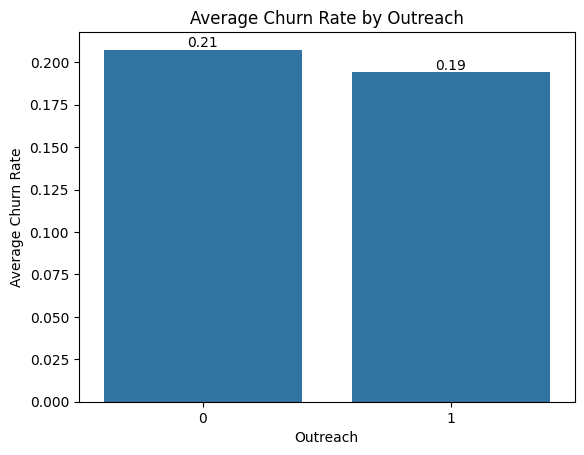

In [122]:
outreach_effect = churn_labels.groupby('outreach').agg({'churn': 'mean'}).reset_index()
ax = sns.barplot(data=outreach_effect, x='outreach', y='churn')
ax.set_xlabel('Outreach')
ax.set_ylabel('Average Churn Rate')
ax.set_title('Average Churn Rate by Outreach')
ax.bar_label(ax.containers[0], fmt='%.2f')

### app_usage feature extraction

In [123]:
# window of 14 days
app_usage.timestamp.min(), app_usage.timestamp.max()

('2025-07-01 00:00:00', '2025-07-14 23:59:51')

In [124]:
app_usage_statistics = app_usage.assign(
    timestamp = pd.to_datetime(app_usage['timestamp'])
).groupby('member_id').agg(
    number_of_sessions = ('timestamp', 'count'),
    first_connection = ('timestamp', 'min'),
    last_connection = ('timestamp', 'max')
).assign(
    days_between = lambda x: (x['last_connection'] - x['first_connection']).dt.days
).assign(
    session_frequency = lambda x: (x['days_between']/ x['number_of_sessions'])
).reset_index()

In [125]:
app_usage_statistics

,member_id,number_of_sessions,first_connection,last_connection,days_between,session_frequency
0,1,6,2025-07-02 19:43:17,2025-07-14 15:28:58,11,1.833333
1,2,10,2025-07-02 07:21:31,2025-07-14 01:37:25,11,1.100000
2,3,9,2025-07-01 18:07:50,2025-07-12 05:42:20,10,1.111111
3,4,10,2025-07-01 10:39:28,2025-07-13 22:17:45,12,1.200000
4,5,10,2025-07-01 08:40:53,2025-07-13 22:06:17,12,1.200000
...,...,...,...,...,...,...
9993,9996,8,2025-07-04 18:06:20,2025-07-14 03:01:11,9,1.125000
9994,9997,11,2025-07-02 23:43:08,2025-07-13 21:30:48,10,0.909091
9995,9998,12,2025-07-01 21:43:50,2025-07-11 20:30:48,9,0.750000
9996,9999,7,2025-07-03 04:37:24,2025-07-13 21:49:01,10,1.428571


In [126]:
app_usage_statistics.describe()

,member_id,number_of_sessions,first_connection,last_connection,days_between,session_frequency
count,9998.000000,9998.000000,9998,9998,9998.000000,9998.000000
mean,5000.181736,9.780856,2025-07-02 11:35:46.645229056,2025-07-13 12:12:40.460492288,10.521404,1.200528
min,1.000000,1.000000,2025-07-01 00:00:00,2025-07-01 07:02:58,0.000000,0.000000
25%,2500.250000,7.000000,2025-07-01 09:46:42.500000,2025-07-12 22:59:42.500000,9.000000,0.888889
50%,4999.500000,10.000000,2025-07-02 00:13:52,2025-07-13 23:27:46.500000,11.000000,1.100000
75%,7500.750000,12.000000,2025-07-03 00:35:56,2025-07-14 14:10:50.500000,12.000000,1.375000
max,10000.000000,26.000000,2025-07-14 00:10:13,2025-07-14 23:59:51,13.000000,6.000000
std,2887.082017,3.625525,NaN,NaN,2.179017,0.484174


### claims feature extraction

In [127]:
claims.diagnosis_date.min(), claims.diagnosis_date.max()

('2025-07-01', '2025-07-14')

In [128]:
claims.value_counts('icd_code')

icd_code
Z71.3    9145
I10      9006
E11.9    8961
H10.9    5414
B34.9    5410
A09      5387
M54.5    5385
J00      5346
R51      5277
K21.9    5245
Name: count, dtype: int64

In [129]:
# One-hot encode the icd_code column and aggregate by member_id
claims_dummies = pd.get_dummies(claims, columns=['icd_code'], dtype='int')
claims_features = claims_dummies.groupby('member_id').agg({
    # Sum all the icd_code dummy columns
    **{col: 'max' for col in claims_dummies.columns if col.startswith('icd_code_')}
}).reset_index()

# count the number of unique icd_codes per member_id
icd_columns = [col for col in claims_features.columns if col.startswith('icd_code_')]
claims_features['code_count'] = claims_features[icd_columns].sum(axis=1)

# count priority conditions
priority_icds = ['icd_code_E11.9', 'icd_code_I10', 'icd_code_Z71.3']
priority_cols = [col for col in priority_icds if col in claims_features.columns]
claims_features['priority_condition_count'] = claims_features[priority_cols].sum(axis=1)
claims_features

,member_id,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3,code_count,priority_condition_count
0,1,0,0,1,0,1,1,0,1,0,1,5,3
1,2,0,0,1,0,1,0,1,0,1,1,5,3
2,3,0,0,1,0,0,0,1,1,0,0,3,1
3,4,1,0,0,0,1,1,0,0,0,0,3,1
4,5,0,0,1,0,1,0,1,1,0,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,9996,1,1,1,0,0,1,0,0,1,1,6,2
9976,9997,0,0,1,0,0,0,1,0,1,1,4,2
9977,9998,0,1,0,1,0,1,1,1,1,1,7,1
9978,9999,0,0,0,0,0,0,1,1,0,1,3,1


### Web_Visits feature extraction

In [130]:
web_visits.value_counts('title')

title
Top destinations              22600
Gadget roundup                22553
Electric vehicles             22395
New releases                  22271
Match highlights              22257
Game reviews                  21337
Dog training                  14636
Budget planning                9791
High-fiber meals               5789
Cholesterol friendly foods     5786
Restorative sleep tips         5697
Hypertension basics            5696
Aerobic exercise               5687
Mediterranean diet             5687
Sleep hygiene                  5672
Exercise routines              5648
Lowering blood pressure        5640
Stress reduction               5620
Diabetes management            5613
Cardiometabolic health         5599
Meditation guide               5597
Healthy eating guide           5595
Strength training basics       5570
Cardio workouts                5548
HbA1c targets                  5535
Weight management              5521
Name: count, dtype: int64

In [131]:
diet_titles = [
    'High-fiber meals', 
    'Cholesterol friendly foods', 
    'Mediterranean diet',
    'Healthy eating guide', 
    'Weight management'
]

physical_activity_titles = [
    'Aerobic exercise',
    'Exercise routines', 
    'Strength training basics', 
    'Cardio workouts'
]

sleep_health_titles = [
    'Restorative sleep tips', 
    'Sleep hygiene'
]

resilience_wellbeing_titles = [
    'Stress reduction',
    'Meditation guide'
]

clinical_titles = [
    'Diabetes management',
    'Hypertension basics',
    'Lowering blood pressure',
    'Cardiometabolic health',
    'HbA1c targets'
]

# Create category columns
web_visits['is_diet'] = web_visits['title'].isin(diet_titles)
web_visits['is_physical_activity'] = web_visits['title'].isin(physical_activity_titles)
web_visits['is_sleep'] = web_visits['title'].isin(sleep_health_titles)
web_visits['is_resilience'] = web_visits['title'].isin(resilience_wellbeing_titles)
web_visits['is_clinical'] = web_visits['title'].isin(clinical_titles)

# if one of the category columns is True, is_health_related is True

web_visits['is_health_related'] = web_visits[['is_diet', 'is_physical_activity', 'is_sleep', 'is_resilience', 'is_clinical']].any(axis=1)
web_visits

,member_id,url,title,description,timestamp,is_diet,is_physical_activity,is_sleep,is_resilience,is_clinical,is_health_related
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22,False,False,False,False,True,True
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47,False,False,False,False,False,False
2,1,https://health.wellco/heart/792,Hypertension basics,Blood pressure and lifestyle changes,2025-07-14 00:38:39,False,False,False,False,True,True
3,2,https://example.com/gaming/674,Game reviews,Strategy tips and updates,2025-07-07 02:56:06,False,False,False,False,False,False
4,2,https://living.better/stress/325,Stress reduction,Mindfulness and wellness,2025-07-02 15:53:38,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
259335,10000,https://example.com/travel/387,Top destinations,City guides and itineraries,2025-07-05 00:05:16,False,False,False,False,False,False
259336,10000,https://guide.wellness/nutrition/261,Cholesterol friendly foods,Lowering LDL and improving lipid profile,2025-07-13 01:15:16,True,False,False,False,False,True
259337,10000,https://media.hub/tech/799,Gadget roundup,Smartphones and laptops news,2025-07-11 01:22:25,False,False,False,False,False,False
259338,10000,https://media.hub/movies/326,New releases,Box office and trailers,2025-07-01 13:55:49,False,False,False,False,False,False


In [143]:
# Aggregate by member
web_features = web_visits.groupby('member_id').agg({
    'is_diet': 'sum',
    'is_physical_activity': 'sum',
    'is_sleep': 'sum',
    'is_resilience': 'sum',
    'is_clinical': 'sum',
    'is_health_related': 'sum',
    'member_id': 'count'  # Count total visits
}).rename(columns={
    'is_diet': 'diet_visits',
    'is_physical_activity': 'physical_activity_visits',
    'is_sleep': 'sleep_visits',
    'is_resilience': 'resilience_visits',
    'is_clinical': 'clinical_visits',
    'is_health_related': 'total_health_visits',
    'member_id': 'total_visits'
}).reset_index()

# Calculate non-relevant visits and ratio
web_features['non_relevant_visits'] = (
    web_features['total_visits'] - web_features['total_health_visits']
)

web_features['health_engagement_ratio'] = (
    web_features['total_health_visits'] / web_features['total_visits']
)

# Add category diversity
web_features['category_diversity'] = (
    (web_features['diet_visits'] > 0).astype(int) +
    (web_features['physical_activity_visits'] > 0).astype(int) +
    (web_features['sleep_visits'] > 0).astype(int) +
    (web_features['resilience_visits'] > 0).astype(int) +
    (web_features['clinical_visits'] > 0).astype(int)
)

web_features

,member_id,diet_visits,physical_activity_visits,sleep_visits,resilience_visits,clinical_visits,total_health_visits,total_visits,non_relevant_visits,health_engagement_ratio,category_diversity
0,1,0,0,0,0,2,2,3,1,0.666667,1
1,2,1,2,1,1,3,8,9,1,0.888889,5
2,3,5,6,4,3,5,23,52,29,0.442308,5
3,4,0,1,2,2,2,7,15,8,0.466667,4
4,5,1,2,2,0,1,6,11,5,0.545455,4
...,...,...,...,...,...,...,...,...,...,...,...
9970,9996,1,2,2,1,7,13,18,5,0.722222,5
9971,9997,2,2,0,0,0,4,8,4,0.500000,2
9972,9998,0,1,1,0,1,3,8,5,0.375000,3
9973,9999,4,3,2,1,2,12,36,24,0.333333,5


# Conclusions from data:

* The time window of the activity recording data is 2 weeks from 2025-07-01 to 2025-07-14.
* The signup to the aplication is between 2024-01-01 and 2025-05-31. all the useres are regestered at least one month to the app.